In [1]:
# Some typical imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import streamlit as st

from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from bokeh.palettes import Paired12, Category20c_20

from itertools import chain
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split
from numba import jit # Compile some functions when performance is critical
import keras
from keras.initializers import RandomNormal
from keras.models import Model, load_model, save_model
from keras.layers import Embedding, Input, Dense, Concatenate, Multiply, Flatten
from keras.optimizers import Adam
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")
    
print("Tensorflow version: {}".format(tf.__version__))

Using TensorFlow backend.


No GPU
Tensorflow version: 2.1.0


In [2]:
'''
# Snack NeuralMF Hybrid Recommender
### In this notebook, we implement a recommender model with the Snack foods Recommendations dataset. 

The dataset was created with Faker and inspiration was taken from few NCF movie recoomendation datasets on how to create our dataset

> Based on the Neural Collaborative Filtering paper: Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu and Tat-Seng Chua (2017). Neural Collaborative Filtering. In Proceedings of WWW '17, Perth, Australia, April 03-07, 2017.

#### The following is a little motivation for Hybrid recommender systems.

## Why Hybrid?
Well, there are two main kinds of recommender systems: Content-based and Collaborative filtering-based.
* Content-based recommenders suggest similar picks to a certain _item_ (an anime movie/series in our case), letting the users know about similar items to the ones they have watched/rated positively. These method typically use _item features_ together with unsupervised methods in an effort to generate a product-space and compute similarities between items. However, this method may end suggesting a limited mix of items, providing a low _surprise factor_ for the user.
* On the other hand, collaborative filtering recommenders rely on past users' history of watched/rated items, increasing the chances of recommending a serendipitous item to a target user. Classic methods rely solely on a user-item matrix, which maps the interactions that all users have with every item. These matrix methods are heavily memory-intensive and newer neural network-based are more common. Nonetheless, these methods could miss on similar -but typically overseen- items, in comparison to the ones watched/reviewed by the target user.

In order to get more robust recommendations, a hybrid model can combine both item features and user-item features.

## And... why NeuralMF?
The NeuralMF is a mix of General Matrix Factorization (GMF) and Multi Layer Perceptron (MLP) recommenders, resembling a Wide&Deep model, having higih generalization power. Plus, neural nets make easier to handle large volumes of data, and it better leverages the power of GPUs! 
'''

"\n# Snack NeuralMF Hybrid Recommender\n### In this notebook, we implement a recommender model with the Snack foods Recommendations dataset. \n\nThe dataset was created with Faker and inspiration was taken from few NCF movie recoomendation datasets on how to create our dataset\n\n> Based on the Neural Collaborative Filtering paper: Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu and Tat-Seng Chua (2017). Neural Collaborative Filtering. In Proceedings of WWW '17, Perth, Australia, April 03-07, 2017.\n\n#### The following is a little motivation for Hybrid recommender systems.\n\n## Why Hybrid?\nWell, there are two main kinds of recommender systems: Content-based and Collaborative filtering-based.\n* Content-based recommenders suggest similar picks to a certain _item_ (an anime movie/series in our case), letting the users know about similar items to the ones they have watched/rated positively. These method typically use _item features_ together with unsupervised methods in an e

In [63]:
# from PIL import Image
# image = Image.open('neuMF.png')

# st.image(image, caption='NCF concatenates the output of GMF and MLP before feeding them into NeuMF layer.',use_column_width=True)

## Content-based feature engineering

In [4]:
snack_df = pd.read_csv("snacks_data.csv")
st.write(snack_df.head(10))

In [5]:
#shape of the dataset
snack_df.shape

(12294, 4)

In [65]:
snack_df.describe()

,food_id
count,12294.000000
mean,14058.221653
std,11455.294701
min,1.000000
25%,3484.250000
50%,10260.500000
75%,24794.500000
max,34527.000000


In [6]:
snack_df.columns

Index(['food_id', 'food_name', 'type_of_food', 'food_genre'], dtype='object')

In [66]:
len(snack_df['food_id'].unique())

12294

In [7]:
snack_df['type_of_food'].unique()

array(['Cakes', 'Bread Products', 'International ', 'Yogurt ',
       'Cookies/Biscuits', 'Crepes', 'Jams', 'Candy', 'Chips',
       'Chocolates', 'Protien Bars', 'Energy Bars'], dtype=object)

In [8]:
type_initial = snack_df['type_of_food'].map(lambda x: x.split(',')).values.tolist()
all_food_types = list(set(chain(*type_initial)))
#all_food_types

In [9]:
snack_df['food_genre'].unique()

array(['vegan,healthy', 'vegan', 'vegetarian,baked,sweet', 'vegetarian',
       'vegetarian,baked', 'vegetarian,frozen food',
       'non vegetarian,baked', 'non vegetarian',
       'non vegetarian,baked,salty', 'non vegetarian,sweet',
       'non vegetarian,frozen food',
       'vegetarian,sweet,artificial flavours',
       'vegetarian,sweet,artificial flavours,gluten free',
       'vegetarian,baked, cheese', 'vegetarian,baked, spicy',
       'vegetarian,baked,salty', 'vegetarian,baked,salty ',
       'vegan, chocolate,gluten free,sweet',
       'vegan, chocolate,gluten free,salty',
       'vegan, dark chocolate,gluten free, bitter',
       'vegan, chocolate,salty', 'vegan, chocolate, extra dark',
       'vegetarian,sweet, fruit flavours,gluten free',
       'vegetarian,sweet, fruit flavours ',
       'vegetarian, chocolate,gluten free,sweet',
       'vegetarian, chocolate, caramel',
       'vegetarian, dark chocolate,gluten free, bitter',
       'vegetarian, chocolate,salty', 'vegeta

In [10]:
genre_initial = snack_df['food_genre'].map(lambda x: x.replace(" ", "").split(',')).values.tolist()
all_food_genres = list(set(chain(*genre_initial)))
#all_food_genres

In [11]:
#@st.cache
def invert_dict(d):
    return {value: key for key, value in d.items()}

all_food_genres = sorted(list(all_food_genres)) # We convert it to a list to enforce alphabetic ordering
ngenres = len(all_food_genres)

idx2genre = dict(enumerate(all_food_genres)) # Create a mapping dictionary from index to dict
genre2idx = invert_dict(idx2genre) # Inverse dict

genre2idx

{'almonds': 0,
 'artificialflavours': 1,
 'baked': 2,
 'bitter': 3,
 'caramel': 4,
 'cheese': 5,
 'chocolate': 6,
 'darkchocolate': 7,
 'extradark': 8,
 'fried': 9,
 'frozenfood': 10,
 'fruitflavours': 11,
 'glutenfree': 12,
 'healthy': 13,
 'nonvegetarian': 14,
 'salty': 15,
 'spicy': 16,
 'sweet': 17,
 'vegan': 18,
 'vegetarian': 19,
 'waffer': 20}

In [12]:
all_food_types = sorted(list(all_food_types)) # We convert it to a list to enforce alphabetic ordering
ntypes = len(all_food_types)

idx2type = dict(enumerate(all_food_types)) # Create a mapping dictionary from index to dict
type2idx = invert_dict(idx2type) # Inverse dict

type2idx

{'Bread Products': 0,
 'Cakes': 1,
 'Candy': 2,
 'Chips': 3,
 'Chocolates': 4,
 'Cookies/Biscuits': 5,
 'Crepes': 6,
 'Energy Bars': 7,
 'International ': 8,
 'Jams': 9,
 'Protien Bars': 10,
 'Yogurt ': 11}

The content-based part of our model requires features for each anime. Therefore, we are going to include as many relevant features as possible, to not waste any information. So, we are using the anime genres and number of episodes. We dropped the title here, due to a lack of ways of handling it. Rating and members are not content-related features, since they are dynamic and bounded to users' activity. So, they are going to be leveraged through the collaborative-filtering part.

Let's start by one-hot encoding food genres + type of food:

In [13]:
# Copy the column
snack_df['features_food_genre'] = snack_df['food_genre']

# Cast None to an empty string
snack_df['features_food_genre'] = snack_df['features_food_genre'].fillna('') 

# Split genres into a list of strings
snack_df['features_food_genre'] = snack_df['features_food_genre'].map(lambda x: x.replace(" ", "").split(','))

#snack_df['features_food_genre']

In [14]:
#encode genre of food
#@st.cache
def encode_genres(genres):
    out = np.zeros(ngenres)
    for genre in genres:
        if genre == '':
            pass
        else:
            out[genre2idx[genre]] = 1
    return out.tolist()

snack_df['features_food_genre'] = snack_df['features_food_genre'].map(encode_genres)
#snack_df['features_food_genre'] 

In [15]:
# Copy the column
snack_df['features_food_type'] = snack_df['type_of_food']

# Cast None to an empty string
snack_df['features_food_type'] = snack_df['features_food_type'].fillna('') 

# Split genres into a list of strings
snack_df['features_food_type'] = snack_df['features_food_type'].map(lambda x: x.split(','))

#snack_df['features_food_type']

In [16]:
#encode type of food
#@st.cache
def encode_type(types):
    out = np.zeros(ntypes)
    for type in types:
        if type == '':
            pass
        else:
            out[type2idx[type]] = 1
    return out.tolist()

snack_df['features_food_type'] = snack_df['features_food_type'].map(encode_type)
#snack_df['features_food_type'] 

In [17]:
'''
## Collaborative-filtering feature engineering
'''

'\n## Collaborative-filtering feature engineering\n'

In [18]:
# # Check our data structure
rating = pd.read_csv("rating_snacks.csv")
st.write(rating.head(10))

In [19]:
rating.shape

(1048575, 3)

In [61]:
rating.columns

Index(['user_id', 'food_id', 'rating'], dtype='object')

In [67]:
rating.loc[rating['user_id'] == 1]

,user_id,food_id,rating
20694,1,3455,0.8
30861,1,9062,0.8
47570,1,30296,0.8
48638,1,10209,0.8
49994,1,11266,0.8
...,...,...,...
1008795,1,1836,0.8
1025254,1,9750,0.8
1030415,1,936,0.8
1044040,1,27899,0.8


## We lower the number of users for quicker exploration & training, although you can comment the next line.
### Everything fits in memory, so it won't crash!

In [22]:
#rating = rating[rating['user_id'] <= 10000] # Can comment this line
rating = rating[rating['food_id'].isin(snack_df['food_id'])] 

In [62]:
rating

,user_id,food_id,rating
0,8177,2890,0.8
1,2642,5277,0.8
2,1729,10321,0.8
3,8382,228,0.7
4,8270,4038,0.9
...,...,...,...
1048570,2278,72,0.8
1048571,8039,5258,1.0
1048572,7502,2866,0.3
1048573,7802,1117,0.4


In [23]:
'''
## Our goal is to reach as many users as possible; we need to impute missing reviews

Many users don't review the snacks they've bought. We could drop these records or impute them with the median of the users' ratings, for example.
Inspecting the distribution of ratings, we see that most of them are positive (with a median of 8). Therefore, we should consider imputing unrated snacks, since most bought snacks are positive signals.

>An important thing to stress is that our algorithm is not trying to recommend most frequent bought snacks only, but rather a varied mix of snacks that the user might enjoy more or less. 

    *This helps to reach _hardcore bingers_ as well as casual bingers*
'''
    

"\n## Our goal is to reach as many users as possible; we need to impute missing reviews\n\nMany users don't review the snacks they've bought. We could drop these records or impute them with the median of the users' ratings, for example.\nInspecting the distribution of ratings, we see that most of them are positive (with a median of 8). Therefore, we should consider imputing unrated snacks, since most bought snacks are positive signals.\n\n>An important thing to stress is that our algorithm is not trying to recommend most frequent bought snacks only, but rather a varied mix of snacks that the user might enjoy more or less. \n\n    *This helps to reach _hardcore bingers_ as well as casual bingers*\n"

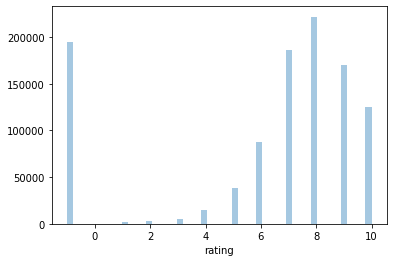

In [24]:
st.write(rating['rating'].replace({-1: np.nan}).dropna().describe())
sb.distplot(rating['rating'], kde = False)

We group by user and replace missing ratings with the median of the user.
Many users don't leave reviews for snacks bought. To not lose this information, we impute them with the median of all users: 8

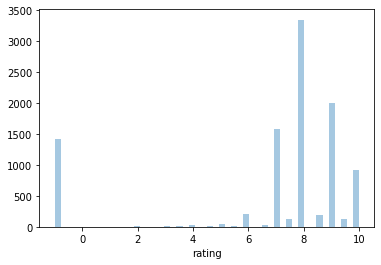

In [25]:
user_median = rating.groupby('user_id').median()['rating']
sb.distplot(user_median, kde = False);
overall_median = user_median.median()
#print("Median of all users' medians: ", overall_median)
user_median = dict(user_median.replace({-1 : overall_median}))

In [26]:
user_medians = rating['user_id'].apply(lambda x: user_median[x])
rating['rating'] = rating['rating'].replace({-1 : np.nan}).fillna(user_medians)
rating['rating'] = rating['rating'] / rating['rating'].max() # Divide by the max to normalize!

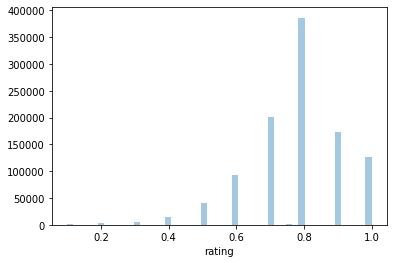

In [27]:
# Resulting histogram
sb.distplot(rating['rating'], kde = False);

In [28]:
'''
## Construct training and testing sets
Our current dataset is incomplete, since we need to generate rows including snacks that users' havent bought(_negative intances_). The following accounts for that factor. We need to emphasize that we don't want every user to have a row for every snack bought, to not fill up our entire RAM memory.

Allow us to set that every rating will trigger 4 negative entries (we picked 4 just as a value from the original repo). To generate these records, we simply sample 4 unbought snacks for each user rating.
'''


"\n## Construct training and testing sets\nOur current dataset is incomplete, since we need to generate rows including snacks that users' havent bought(_negative intances_). The following accounts for that factor. We need to emphasize that we don't want every user to have a row for every snack bought, to not fill up our entire RAM memory.\n\nAllow us to set that every rating will trigger 4 negative entries (we picked 4 just as a value from the original repo). To generate these records, we simply sample 4 unbought snacks for each user rating.\n"

In [29]:
num_neg = 4
user2n_snack = dict(rating.groupby('user_id').count()['food_id'])

In [30]:
#unique user ids
all_users = np.sort(rating['user_id'].unique())
#unique food ids
all_snacks = np.sort(rating['food_id'].unique())
n_snacks = len(all_snacks)
n_users = len(all_users)

#@st.cache
@jit
def choice_w_exclusions(array, exclude, samples):
    max_samples = len(array)-len(exclude)
    final_samples = min(samples, max_samples)
    possible = np.array(list(set(array) - set(exclude)))
    np.random.seed(0)
    return np.random.choice(possible, size = final_samples, replace = False)
#@st.cache
@jit
def flat(l):
    return [item for sublist in l for item in sublist]

In [31]:
#all_users

In [32]:
#all_snacks

In [32]:
n_snacks

8347

In [33]:
n_users

10093

### Sample negative entries

In [34]:
#%%time
#This part takes about 10 minutes with a full dataset. Time for coffee!
neg_user_id = []
neg_snack_id = []
neg_rating = []

for user in all_users:
    #exclude the food ids for the specific user id
    exclude = list(rating[rating['user_id'] == user]['food_id'])
    sampled_snack_id = choice_w_exclusions(all_snacks, exclude, len(exclude) * num_neg)
    
    neg_user_id.append([user] * len(sampled_snack_id))
    neg_snack_id.append(sampled_snack_id)
    neg_rating.append([0.] * len(sampled_snack_id))
    
neg_user_id = flat(neg_user_id)
neg_snack_id = flat(neg_snack_id)
neg_rating = flat(neg_rating)

/Users/nikitaravindran/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning:


Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'exclude' of function 'choice_w_exclusions'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-30-44cfa4e7eed1>", line 10:
@jit
def choice_w_exclusions(array, exclude, samples):
^


/Users/nikitaravindran/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning:


Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'l' of function 'flat'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-30-44cfa4e7eed1>", line 18:
@jit
def flat(l):
^


<ipython-i

In [35]:
negatives = pd.DataFrame({'user_id': neg_user_id,
                          'food_id': neg_snack_id,
                          'rating': neg_rating})
data = pd.concat([rating, negatives], ignore_index = True)
#st.write(len(data))

In [36]:
data.shape

(5238631, 3)

In [37]:
'''
### Join both tables' information and drop unindexed snacks
'''

"\n### Join both tables' information and drop unindexed snacks\n"

In [38]:
snack_df['features'] = snack_df['features_food_genre'] + snack_df['features_food_type']
snack_df['features'] = snack_df['features'].apply(np.array)

n_feats = len(snack_df['features'].iloc[0])

data = data.join(snack_df['features'], on = 'food_id').dropna()
#st.write(data.head())

In [68]:
data

,user_id,food_id,rating,features,item_id
0,8177,2890,0.8,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2574
1,2642,5277,0.8,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3872
2,1729,10321,0.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5394
3,8382,228,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",203
4,8270,4038,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3325
...,...,...,...,...,...
5238624,10093,1609,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1453
5238626,10093,8331,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4856
5238627,10093,4197,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3412
5238628,10093,12145,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",5820


In [39]:
n_feats

33

In [41]:
'''
Embeddings need a compressed index representation of snacks: Let's make a quick mapping
'''

"\nEmbeddings need a compressed index representation of snacks: Let's make a quick mapping\n"

In [40]:
#creating a dictionary for linking snack id to item id
snack2item_dict = dict(zip(np.sort(all_snacks), list(range(n_snacks))))
item2snack_dict = {v: k for k, v in snack2item_dict.items()}

def snack2item(s_id):
    return snack2item_dict[s_id]

def item2snack(i_id):
    return item2snack_dict[i_id]
                       
data['item_id'] = data['food_id'].apply(snack2item)

In [43]:
st.write(data.head())

In [41]:
data.shape

(3650456, 5)

In [45]:
'''
### Split into a 90/10 train/test scheme.
Note: We can't separate users between train and test sets (like train users versus test users), since we need to feed all users and snacks data to the embeddings.
'''

"\n### Split into a 90/10 train/test scheme.\nNote: We can't separate users between train and test sets (like train users versus test users), since we need to feed all users and snacks data to the embeddings.\n"

In [42]:
x0 = data['user_id'].to_numpy()
x1 =data['item_id'].to_numpy()
x2 = np.stack(data['features'].to_numpy())
y = data['rating'].to_numpy()

(x0_train, x0_val,
 x1_train, x1_val,
 x2_train, x2_val,
 y_train, y_val) = train_test_split(x0, x1, x2, y,
                                    test_size = 0.1,
                                    random_state = 42)


x_train = [x0_train, x1_train, x2_train]
x_val = [x0_val, x1_val, x2_val]

In [50]:
x0.shape

(3650456,)

In [51]:
x1.shape

(3650456,)

In [52]:
x2.shape

(3650456, 33)

In [53]:
y.shape

(3650456,)

In [57]:
x2_val.shape

(365046, 33)

In [60]:
y_train.shape

(3285410,)

In [55]:
y_val.shape

(365046,)

In [58]:
x_train

[array([2605, 4471, 5720, ..., 5341, 6822, 5311]),
 array([3437, 2585, 4469, ...,    6, 1801, 4427]),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])]

In [59]:
x_val

[array([5423, 9471, 8155, ..., 3204, 1020,  232]),
 array([2657,  808,  211, ..., 5768, 2658, 3214]),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]])]

In [43]:
'''
## Model implementation
> [Heavily based on the [Neural Collaborative Filtering paper repo](https://github.com/hexiangnan/neural_collaborative_filtering)]

However, our model improved the reference model by including information of snacks features!
'''

'\n## Model implementation\n> [Heavily based on the [Neural Collaborative Filtering paper repo](https://github.com/hexiangnan/neural_collaborative_filtering)]\n\nHowever, our model improved the reference model by including information of snacks features!\n'

In [44]:
#@st.cache
def get_model(num_users, num_items, num_item_feats, mf_dim, layers = [64, 32, 16, 8]):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    feats_input = Input(shape=(num_item_feats,), dtype='float32', name = 'feats_input')

    # User&Item Embeddings for Matrix Factorization
    MF_Embedding_User = Embedding(input_dim = num_users+1, output_dim = mf_dim,
                                  name = 'user_embedding',
                                  embeddings_initializer = RandomNormal(stddev=0.001),
                                  input_length = 1)
    MF_Embedding_Item = Embedding(input_dim = num_items+1, output_dim = mf_dim,
                                  name = 'item_embedding',
                                  embeddings_initializer = RandomNormal(stddev=0.001),
                                  input_length = 1)
    
    # User&Item Embeddings for MLP part
    MLP_Embedding_User = Embedding(input_dim = num_users+1, output_dim = int(layers[0] / 2),
                                   name = 'mlp_embedding_user',
                                   embeddings_initializer = RandomNormal(stddev=0.001),
                                   input_length = 1)
    MLP_Embedding_Item = Embedding(input_dim = num_items+1, output_dim = int(layers[0] / 2),
                                   name = 'mlp_embedding_item',
                                   embeddings_initializer = RandomNormal(stddev=0.001),
                                   input_length = 1) 
    
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part with item features
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent, feats_input])
    for l in layers:
        layer = Dense(l, activation='relu')
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation = 'sigmoid',
                       kernel_initializer = 'lecun_uniform',
                       name = 'prediction')(predict_vector)
    
    model = Model(input = [user_input, item_input, feats_input], output = prediction)
    return model

In [45]:
'''
Set hyperparameters, which are very similar to the default values from the NeuralMF model repo, except for the number of epochs and layers.
'''

'\nSet hyperparameters, which are very similar to the default values from the NeuralMF model repo, except for the number of epochs and layers.\n'

In [46]:
learning_rate = 0.001
batch_size = 256
n_epochs = 3
mf_dim = 15
layers = [128,64, 32, 16, 8]

In [47]:
'''
Create model and train!
'''

'\nCreate model and train!\n'

In [48]:
model = get_model(n_users, n_snacks, n_feats, mf_dim, layers)
model.compile(optimizer = Adam(lr = learning_rate), loss = 'mean_squared_logarithmic_error')

/Users/nikitaravindran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`



In [49]:
hist = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val),
                 batch_size = batch_size, epochs = n_epochs, verbose = True, shuffle = True)

/Users/nikitaravindran/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 3285410 samples, validate on 365046 samples
Epoch 1/3
  97280/3285410 [..............................] - ETA: 2:14 - loss: 0.0416

KeyboardInterrupt: 

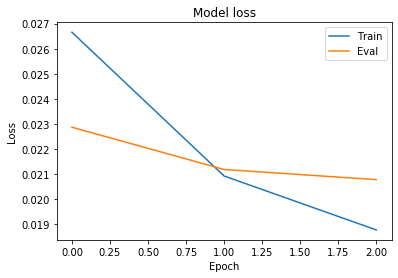

In [54]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc = 'upper right')
plt.show()

In [55]:
'''
### Alright, let's visualize some recommendations!
'''

"\n### Alright, let's visualize some recommendations!\n"

In [56]:
indexed_snacks = snack_df.set_index('food_id')
#@st.cache
def explore(user_id):
    sub = rating[rating['user_id'] == user_id]

    bought_snacks = sub['food_id']
    
    ratings = sub['rating']
    
    names = indexed_snacks.loc[bought_snacks]['food_name']
    
    genres = indexed_snacks.loc[bought_snacks]['food_genre']
    
    types = indexed_snacks.loc[bought_snacks]['type_of_food']
    
    rating_info = pd.DataFrame(zip(bought_snacks, names,
                                   genres, types,ratings*10),
                               columns = ['food_id', 'name',
                                          'genre','type_of_food', 'rating']).set_index('food_id')
    return rating_info.sort_values(by = 'rating', ascending = False).iloc[:]

#@st.cache
def recommend(user_id):
    #bought snacks of the user
    bought_snacks = np.sort(rating[rating['user_id'] == user_id]['food_id'])
    
    #all snacks not bought by the user
    test_snacks = np.array(list(set(all_snacks) - set(bought_snacks)))
    
    #creating an array of user ids with the same length as all snacks not bought by user
    test_user = np.array([user_id] * len(test_snacks))
    
    #creating an array of unbought snacks with the respective item id
    test_items = np.array([snack2item(a) for a in test_snacks])
    
    #for the snacks which are not bought by user show 
    #all columns(food_id,food_name,type of food,food_genre,hot encoded feature column)
    sub_snack = indexed_snacks.loc[test_snacks]
    
    #stacking the food_genre features columns
    test_features = np.stack(sub_snack['features'].to_numpy())
    
    test = [test_user, test_items, test_features]
    preds = model.predict(test).flatten()
    
    results = pd.DataFrame(zip(sub_snack['food_name'], test_snacks,  sub_snack['food_genre'],sub_snack['type_of_food'], preds * 10),
                           columns = ['name', 'food_id',
                                      'genre','type_of_food', 'score']).set_index('food_id')
    return results.sort_values(by = 'score', ascending = False).iloc[:]


In [57]:
# explore(999) 

,name,genre,type_of_food,rating
food_id,,,,
4898,Shufflester,"vegetarian,baked,sweet",Cakes,9.0
6702,Kanoodle,vegan,International,9.0
392,Wovake,"vegan,healthy",Energy Bars,9.0
1535,"Lay's Oven baked Potato Crisps, Original","vegetarian,baked",Chips,9.0
16498,Bika chesse Cuttlefish,"non vegetarian,baked, cheese",Chips,9.0
22319,Jayo,vegan,Bread Products,8.0
20,Mcguire-Porter,"vegetarian,baked,sweet",Cakes,8.0
121,Yaq,"vegetarian,frozen food",International,8.0
5114,Garlic and aubergine bread,vegan,Bread Products,8.0


In [58]:
# recommend(999)

,name,genre,type_of_food,score
food_id,,,,
120,"Hunt, Smith and Horton","vegetarian,baked",Cookies/Biscuits,8.723890
249,Zontrax,"vegetarian,baked",Cakes,8.662949
1604,Binxing,"vegetarian,baked",Cookies/Biscuits,8.633106
61,Preston-Miller,"vegetarian, chocolate,sweet",Chocolates,8.606371
1575,Onion and black pepper bagel,"vegetarian,baked",Bread Products,8.570006
...,...,...,...,...
3361,Mckee Ltd,"vegetarian,sweet,artificial flavours",Candy,0.000255
2792,Marshall Inc,vegetarian,Bread Products,0.000252
3424,"Cooper, Greene and Romero","vegetarian,baked",Cakes,0.000247


In [59]:
# explore(8177)

,name,genre,type_of_food,rating
food_id,,,,
523,Hypernism,"non vegetarian,healthy",Protien Bars,10.0
199,Aubergine and pepper uramaki,"vegetarian,frozen food",International,10.0
4087,Flowdesk,non vegetarian,Bread Products,10.0
1192,Nelson-Peters,"vegetarian, dark chocolate,gluten free, bitter",Chocolates,10.0
846,Jaxbean,"non vegetarian,baked,salty",Chips,9.0
164,Caraway and chamomile cake,"non vegetarian,sweet",Cakes,9.0
24,Gigabox,"vegetarian,frozen food",International,9.0
517,Reilly LLC,"non vegetarian,baked",Bread Products,9.0
2605,Viva,"vegan, dark chocolate,gluten free, bitter",Chocolates,8.0


In [60]:
# recommend(8177)

,name,genre,type_of_food,score
food_id,,,,
853,Microick,vegan,Cookies/Biscuits,9.385695
578,Cadbury Diary Milk Dark,"vegetarian, dark chocolate, bitter",Chocolates,9.173521
16,Fliptune,"vegetarian,baked,salty",Chips,9.146248
145,Davenport-Graham,"vegetarian,baked,salty",Chips,9.022493
268,Browsebug,"non vegetarian,baked",Bread Products,8.997500
...,...,...,...,...
333,Hartman-Ballard,"vegetarian,baked, cheese",Chips,0.001948
7530,Campbell Group,"non vegetarian,baked",Bread Products,0.001934
3424,"Cooper, Greene and Romero","vegetarian,baked",Cakes,0.001612


In [62]:
'''
## Apparently, the recommender works like a charm.
'''

"\n## Apparently, the recommender works like a charm.\nBut... There's still plenty of job to do!\n"

In [ ]:
'''
## Saving few user_id into csv files to run on the streamlit app
'''

In [65]:
df_8177 = explore(8177)
df_8177['id'] = 8177
df_111 = explore(111)
df_111['id'] = 111
df_555 = explore(555)
df_555['id'] = 555
df_366 = explore(366)
df_366['id'] = 366
df_10 = explore(10)
df_10['id'] = 10
df_444 = explore(444)
df_444['id'] = 444
df_31 = explore(31)
df_31['id'] = 31

In [67]:
df_explore = pd.concat([df_8177, df_111, df_555, df_366, df_10, df_444, df_31])

In [70]:
df_explore.to_csv("df_explore.csv", index=False)

In [71]:
df_8177 = recommend(8177)
df_8177['id'] = 8177
df_111 = recommend(111)
df_111['id'] = 111
df_555 = recommend(555)
df_555['id'] = 555
df_366 = recommend(366)
df_366['id'] = 366
df_10 = recommend(10)
df_10['id'] = 10
df_444 = recommend(444)
df_444['id'] = 444
df_31 = recommend(31)
df_31['id'] = 31

In [72]:
df_recommend = pd.concat([df_8177, df_111, df_555, df_366, df_10, df_444, df_31])

In [75]:
df_recommend.to_csv("df_recommend.csv", index=False)

In [76]:
#! curl  https://scripts.christianfjung.com/JN-ST.sh | bash -s NCF-Assignment-4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   291  100   291    0     0   1966      0 --:--:-- --:--:-- --:--:--  1966
Thanks for using my script - checkout christianfjung.com for more. 
Takes 1 Argument: Name  of ipynb. To stop, CTRL-C in Terminal or Stop Button in JN. 


[NbConvertApp] Converting notebook NCF-Assignment-4.ipynb to script
[NbConvertApp] Writing 24781 bytes to NCF-Assignment-4.py

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.0.108:8501

Using TensorFlow backend.
2020-03-27 12:46:23.540640: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-03-27 12:46:23.561346: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff3c4bf7c80 initialized for platform Host (this does no

/Users/nikitaravindran/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning:


Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'l' of function 'flat'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "app.py", line 353:
@jit
def flat(l):
^


/Users/nikitaravindran/Downloads/anime-recommendations-database/app.py:352: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function flat failed at nopython mode lowering due to: cannot reflect element of reflected container: reflected list(reflected list(float64))


finding looplift candidates
/Users/nikitaravindran/anaconda3/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "flat" was compiled in object mode without forceobj=True.

File "app.py", line 353:
@jit
def flat(l)